This notebook demonstrates the functionality in the codebase for training single and federated DP models.

Part of code and documentation for the paper #citation here

## Setup

In [1]:
import os
import os.path
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 7, 5

In [2]:
from src.modeling.train_utils import trainer_setup, adamopt, DPTraining, Predict
from src.modeling.models import seresnet18
from src.modeling.metrics import roc_curves_notebook
from src.dataloader.dataset import dataloader
from src.dataloader.silo import get_silos, get_experiment_seed

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [4]:
RANDOM_SEED = 42

The DP library Opacus spams quite a lot of warnings which are actually harmless. The following code is generally not recommended, but will keep this notebook cleaner.

In [5]:
import warnings
warnings.simplefilter("ignore")

## Training a single model

### Data

The code in this repository assumes file structure, where the ECG waveform files are under `data/processed_data/Silo_name/` and CSV files with metadata and labels are under `data/split_csvs/Silo_name`.

Instructions to prepare the training data from PhysioNet CinC 2020/2021 challenge/Shandong Provincial Hospital: https://github.com/UTU-Health-Research/dl-ecg-classifier/blob/main/notebooks/1_setup_runs.ipynb

For now, we will assume that we have the files from the SPH and G12EC datasets:
```
data
├── processed_data
│   └── SPH
│   │   ├── SPH00001_preprocessed.h5
│   │   ├── SPH00002_preprocessed.h5
│   │   ├── SPH00003_preprocessed.h5
...
│   ├── G12EC
│   │   ├── E00001_preprocessed.hea
│   │   ├── E00001_preprocessed.mat
│   │   ├── E00002_preprocessed.hea
...
└── split_csvs
    ├── SPH
    │   ├── clean_all_sph.csv
    │   ├── clean_all_sph_10_perc.csv
...
    ├── G12EC
    │   ├── clean_all_g12ec.csv
    │   ├── clean_all_g12ec_10_perc.csv
...
```

In [6]:
# random 10% subsample for testing
df = pd.read_csv("data/split_csvs/SPH/clean_all_sph_10_perc.csv")

In [7]:
# class labels
CINC_LABELS = df.columns.tolist()[4:]

Make sure the path of the data files is correct

In [8]:
df.head()

,path,age,gender,fs,426783006,426177001,164934002,427393009,713426002,427084000,...,164889003,59931005,47665007,445118002,39732003,164890007,164909002,270492004,251146004,284470004
0,data/processed_data/SPH/SPH17712_preprocessed.h5,62,Male,250,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,data/processed_data/SPH/SPH00527_preprocessed.h5,60,Male,250,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,data/processed_data/SPH/SPH19959_preprocessed.h5,83,Male,250,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,data/processed_data/SPH/SPH08373_preprocessed.h5,54,Female,250,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,data/processed_data/SPH/SPH08795_preprocessed.h5,39,Male,250,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train the model

In DP training, BATCH_SIZE is used to calculate the sampling rate q = BATCH_SIZE / dataset size.
`src.modeling.train_utils.PHYS_BATCH_SIZE` is the batch size used in actual computation

In [9]:
BATCH_SIZE = 1024
IN_CHANNELS = 12  # 12-lead ECG
CHECKPOINT_PATH = "checkpoints"  # checkpoints directory for the trainer class

In [10]:
train_ds = dataloader(df, train=True, batch_size=BATCH_SIZE)

`v4` is the small model architecture for testing

In [11]:
model = seresnet18.resnet18(RANDOM_SEED, "v4", in_channel=IN_CHANNELS, out_channel=len(CINC_LABELS))

Setting seed to 42


In [12]:
t = DPTraining(model, adamopt, train_ds, CINC_LABELS, device, CHECKPOINT_PATH, name="SPH")

Make the training process private. Set epsilon 10, clipping norm 0.7 and inform the trainer that training will last 20 epochs

In [13]:
t.make_private(10.0, 0.7, 20)

In [14]:
train_hist = t.train(20)

epoch  1  [981/2328] train loss:  0.56
epoch  1  [2069/2328] train loss:  0.46
SPH epoch  1  / 20  train loss: 0.560   train macro auroc: 0.469 
epoch  2  [993/2328] train loss:  0.40
epoch  2  [1961/2328] train loss:  0.35
SPH epoch  2  / 20  train loss: 0.392   train macro auroc: 0.456 
epoch  3  [1029/2328] train loss:  0.25
epoch  3  [2111/2328] train loss:  0.20
SPH epoch  3  / 20  train loss: 0.250   train macro auroc: 0.438 
epoch  4  [1150/2328] train loss:  0.18
epoch  4  [2138/2328] train loss:  0.19
SPH epoch  4  / 20  train loss: 0.192   train macro auroc: 0.453 
epoch  5  [999/2328] train loss:  0.30
epoch  5  [2007/2328] train loss:  0.33
SPH epoch  5  / 20  train loss: 0.302   train macro auroc: 0.443 
epoch  6  [1003/2328] train loss:  0.36
epoch  6  [2035/2328] train loss:  0.38
SPH epoch  6  / 20  train loss: 0.377   train macro auroc: 0.434 
epoch  7  [984/2328] train loss:  0.33
epoch  7  [1982/2328] train loss:  0.33
SPH epoch  7  / 20  train loss: 0.327   train ma

Display the privacy budget computed each epoch by the moments accountant, and the automatically set privacy parameters

In [15]:
t.summary_stats()

{'epsilon': [2.0920881806234113,
  2.787520400543371,
  3.3361693053666532,
  3.8100683236610404,
  4.23586904590755,
  4.628309552643664,
  4.994807994062005,
  5.341860684594294,
  5.671473154952598,
  5.986983505034776,
  6.291028669590108,
  6.585431148961249,
  6.868836866648121,
  7.144534925457538,
  7.415005032809966,
  7.676553288949845,
  7.933661459341108,
  8.184628884669499,
  8.431599511713625,
  8.672208213328762],
 'delta': 4.29553264604811e-05,
 'sigma': 1.6748046875}

### Test on a different dataset

The model is far from state of the art with the amount of data and training we used, but let's test it

In [16]:
df_test = pd.read_csv("data/split_csvs/G12EC/clean_all_g12ec_10_perc.csv")

In [17]:
test_ds = dataloader(df_test, train=False)

Take the model directly from the trainer. While we had to supply the checkpoints path, we did not configure the trainer to actually save checkpoints yet

In [18]:
p = Predict(t.model, test_ds, CINC_LABELS, device)

1   /   4 predictions made
macro avg prec: 0.135  micro avg prec: 0.155  macro auroc: 0.559  micro auroc: 0.667  


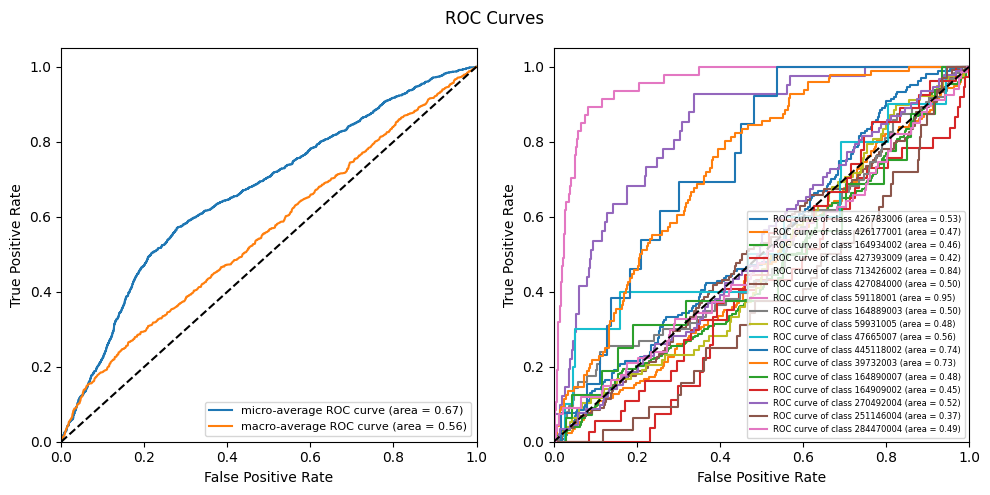

In [19]:
hist_eval = p.evaluate(roc_curves_notebook)

## Federated Learning

Here we will train a DP-FedAvg model. To see how to use other algorithms, check the `dp_training.py` script

### Data

Previously we loaded two datasets manually. For federated learning, we will assume that at least all of the datasets in the CinC challenge and SPH are present, and use automated loading.

The location of data is configured in `src/dataloader/silo.py`

In [20]:
silos, CINC_LABELS = get_silos(subset="small")

In [21]:
TEST_SILO = "G12EC"
train_silos = dict((k, v) for k, v in silos.items()
                   if k in ["ChapmanShaoxing_Ningbo", "CPSC_CPSC-Extra", "PTB_PTBXL", "SPH"])
test_silos = {TEST_SILO: silos[TEST_SILO]}

### Setup

In [22]:
from src.federated.dpfl import FederatedFlow, fl_setup

Aggregator step "start" registered
Aggregator step "select_collaborators" registered
Collaborator step "train" registered
Aggregator step "join" registered
Aggregator step "internal_loop" registered
Collaborator step "final_report" registered
Aggregator step "end" registered
Collaborator step "train" registered
Aggregator step "join" registered
Collaborator step "train" registered
Collaborator step "train" registered
Aggregator step "join" registered
Aggregator step "join" registered
Collaborator step "final_report" registered
Aggregator step "end" registered
Collaborator step "train" registered
Aggregator step "join" registered


In [23]:
def trainers_setup(train_silos, device, cp_path, optfunc=adamopt, privacy_params={}, experiment_id=0, trainer_class=None):
    train_names = list(train_silos.keys())
    labels = train_silos[train_names[0]].columns.tolist()[4:]

    trainers = {}
    for k in train_names:
        train_dl = dataloader(train_silos[k], device)
        cp_params = {"path": cp_path, "freq": None}
        seed = get_experiment_seed(k, experiment_id)
        model = seresnet18.resnet18(seed, "v4", in_channel=IN_CHANNELS, out_channel=len(labels))
    
        trainers[k] = trainer_setup(model, train_dl, labels, device, optfunc,
                cp_params=cp_params, privacy_params=privacy_params, name=k, trainer_class=trainer_class)

    return trainers

In [24]:
os.environ["USERNAME"] = "user"

The federated training process will save checkpoints, so make sure the directory exists

In [25]:
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

### Training

In [26]:
local_runtime = fl_setup(train_silos)

`e_epochs` is "expected epochs". If each silo participates each round, this is `num_rounds * local_epoch`.

In [27]:
local_trainers = trainers_setup(train_silos, device, CHECKPOINT_PATH, privacy_params={"epsilon": 10.0, "max_grad_norm": 1.0, "e_epochs": 20})

Setting seed to 662418406
Setting seed to 10974390
Setting seed to 71810256
Setting seed to 182173961


Always run trainers_setup() before running this cell (collaborators have persistent state that needs to be re-initialized)

In [28]:
%%capture torch_output_log_text
federated_flow = FederatedFlow(num_rounds=10, local_epoch=2, n_collab=4, cp_path=CHECKPOINT_PATH, trainer_log=False)
federated_flow.runtime = local_runtime
federated_flow.get_trainer = lambda x: local_trainers[x]
federated_flow.run()

In [29]:
# uncomment to see the output (expect lots of spam)
#print(torch_output_log_text)

### Test on hold out silo

In [30]:
with np.load(os.path.join(CHECKPOINT_PATH, "fl_global_cp_10.npz")) as npz:
    checkpoint_weights = [npz[arr_name] for arr_name in npz.files]

In [31]:
model = seresnet18.resnet18(RANDOM_SEED, "v4", in_channel=IN_CHANNELS, out_channel=len(CINC_LABELS))

Setting seed to 42


In [32]:
test_ds = dataloader(test_silos[TEST_SILO], train=False)
p = Predict(model, test_ds, CINC_LABELS, device)
p.set_weights(checkpoint_weights)

1   /   4 predictions made
macro avg prec: 0.138  micro avg prec: 0.164  macro auroc: 0.581  micro auroc: 0.704  


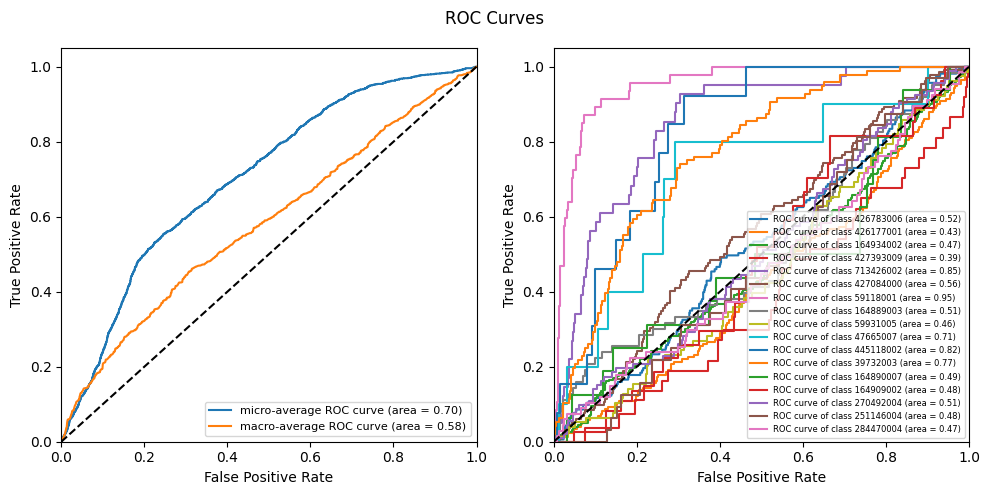

In [33]:
hist_eval = p.evaluate(roc_curves_notebook)

### Training stats

In [34]:
federated_flow.summary

{'ChapmanShaoxing_Ningbo': {'epsilon': [3.204083341966351,
   3.8610119451571014,
   4.388843967224862,
   4.851490313587987,
   5.267300127234828,
   5.653413779845327,
   6.0164303117186995,
   6.362207125737323,
   6.686959026571956,
   7.001045938061699,
   7.305949705573772,
   7.596422703228168,
   7.882925529475111,
   8.157324802374017,
   8.42669257139493,
   8.692364518821007,
   8.945711122842832,
   9.199057726864657,
   9.448453933838678,
   9.686765070538858],
  'delta': 2.295684113865932e-05,
  'sigma': 0.88470458984375},
 'CPSC_CPSC-Extra': {'epsilon': [2.074070276761498,
   2.7846665342854307,
   3.3481123920809384,
   3.83595064740995,
   4.276091723689846,
   4.682125957882339,
   5.063621346631323,
   5.4228759902807,
   5.765822415883853,
   6.095271913742313,
   6.413767639788879,
   6.718729753588328,
   7.015869342821736,
   7.307624716061689,
   7.587208893846451,
   7.866013754224094,
   8.132325689566548,
   8.398637624909002,
   8.656300309980066,
   8.91035

In [35]:
def plot_progression(progr_stats, key="train_loss"):
    collab_names = progr_stats.keys()
    for k in collab_names:
        if k in progr_stats and key + "_x" in progr_stats[k]:
            y = progr_stats[k][key + "_y"]
            x = progr_stats[k][key + "_x"]
            plt.plot(x, y, label=k)

In [36]:
def train_progression(progr_stats):
    plot_progression(progr_stats, "train_loss")
    plt.ylabel("Training loss")
    plt.legend(loc="lower right")
    plt.xlabel("federated round")
    plt.axhline(y=0, color='k')
    plt.show()

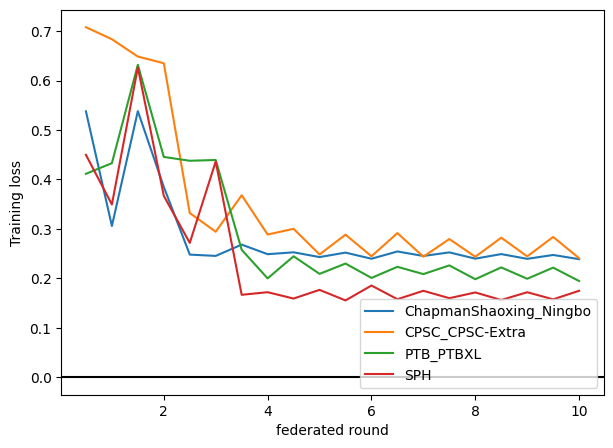

In [37]:
train_progression(federated_flow.stats)